In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from haversine import haversine
import folium
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


In [3]:
def haversine(lon1, lat1, lon2, lat2):
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a))
  r = 6371
  return c * r


In [4]:
acceleration = pd.read_csv('Acceleration_data.csv')
acceleration.head()

,Unnamed: 0,seconds_elapsed,z,y,x
0,0,0.143440,-2.846008,-0.581977,-0.468246
1,1,0.159217,-2.651466,-0.560432,-0.418557
2,2,0.175117,-2.132024,-0.366186,-0.535990
3,3,0.190986,-1.023350,-0.041039,-0.522485
4,4,0.206763,-0.449766,0.229015,-0.356920


In [9]:
data = pd.read_csv('GPS_data.csv')
data.head()

,Unnamed: 0,seconds_elapsed,longitude,latitude
0,0,3.703666,25.516165,65.071375
1,1,5.339879,25.516227,65.071393
2,2,5.680000,25.516240,65.071398
3,3,6.311351,25.516264,65.071394
4,4,7.323929,25.516267,65.071396


In [15]:
def calculate_distance_and_time(data):
    lat = data['latitude']
    lon = data['longitude']
    
    data['dist'] = np.zeros(lat.shape[0])
    data['time_diff'] = np.zeros(lat.shape[0])

    for i in range(lat.shape[0] - 1):
        data['dist'][i] = haversine((lon[i], lat[i]), (lon[i+1], lat[i+1])) * 1000
        data['time_diff'][i] = data['seconds_elapsed'][i+1] - data['seconds_elapsed'][i]

    # Set the first distance value to 0
    data.at[0, 'dist'] = 0

    # Calculate velocity
    data['velocity'] = data['dist'] / data['time_diff']

    return data
  
data.head()


,Unnamed: 0,seconds_elapsed,longitude,latitude,dist,time_diff,velocity
0,0,3.703666,25.516165,65.071375,0.000000,1.636214,0.000000
1,1,5.339879,25.516227,65.071393,0.810401,0.340121,2.382686
2,2,5.680000,25.516240,65.071398,1.171329,0.631351,1.855274
3,3,6.311351,25.516264,65.071394,0.229699,1.012578,0.226845
4,4,7.323929,25.516267,65.071396,0.722069,1.005767,0.717928


In [52]:
location_frame = data[['latitude', 'longitude']]
location_list = location_frame.values.tolist()

ave_lat = np.mean(location_list, axis=0)[0]
ave_lon = np.mean(location_list, axis=0)[1]

# Create a map centered at the average location
my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=16)

# Add polyline representing the route
folium.PolyLine(location_list, color="blue", weight=3, opacity=1).add_to(my_map)

# Save the map as an HTML file
my_map.save("gps_map.html")

# Display the map here
my_map

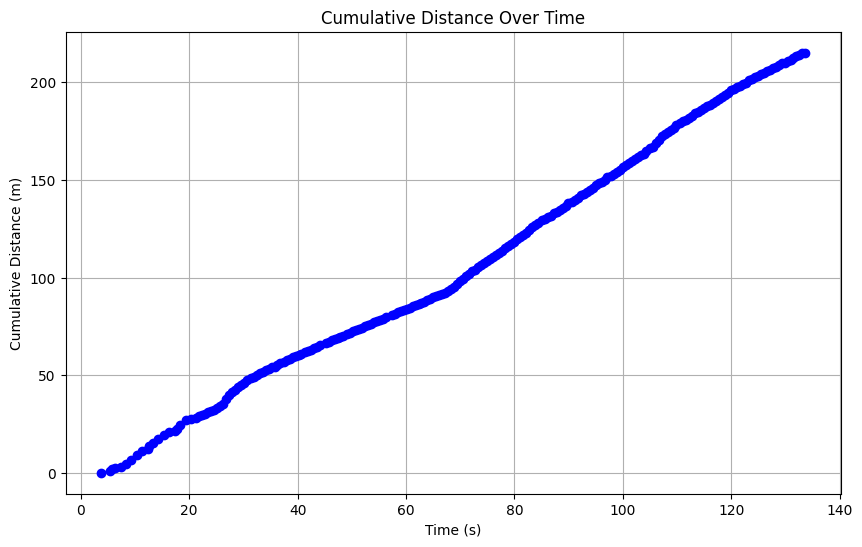

In [23]:
data['cumulative_dist'] = data['dist'].cumsum()

# Plot cumulative distance over time
plt.figure(figsize=(10, 6))
plt.plot(data['seconds_elapsed'], data['cumulative_dist'], color='blue', marker='o', linestyle='-')
plt.title('Cumulative Distance Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Distance (m)')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Velocity')

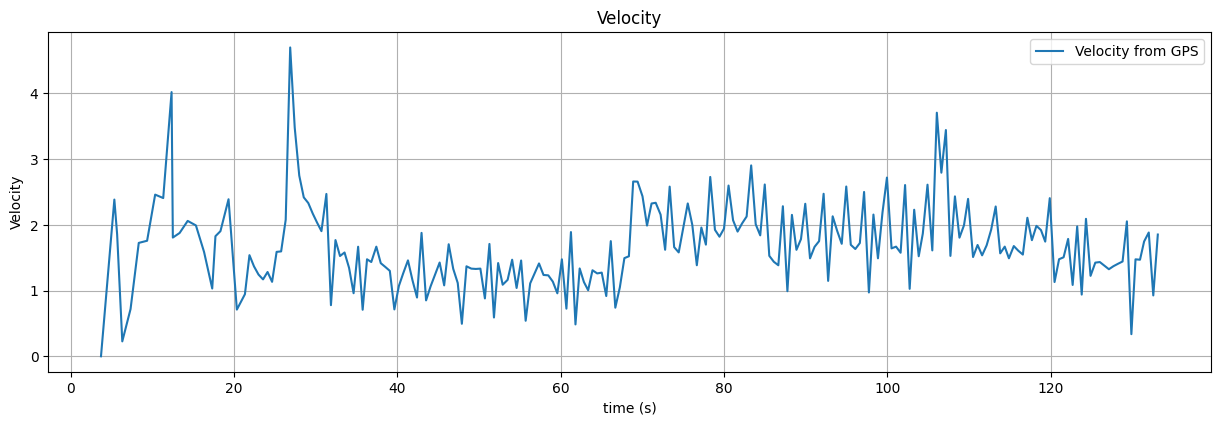

In [24]:
plt.figure(figsize=(15,15))

plt.subplot(3, 1, 1)
plt.plot(data['seconds_elapsed'], data['velocity'])
plt.grid()
plt.legend(["Velocity from GPS", 'Velocity from app'])
plt.title("Velocity")
plt.xlabel("time (s)")
plt.ylabel("Velocity")

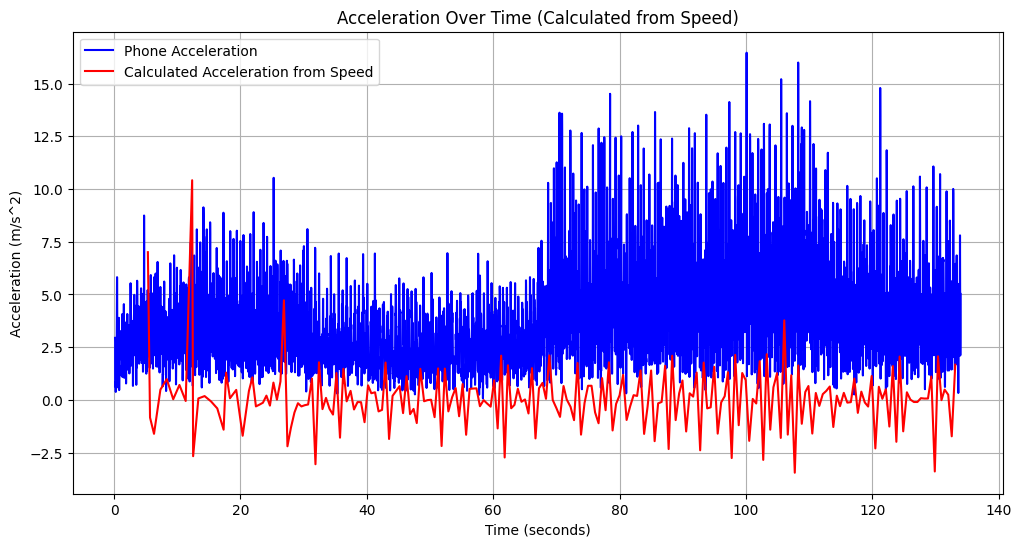

In [30]:
acceleration['magnitude'] = np.sqrt(acceleration['x']**2 + acceleration['y']**2 + acceleration['z']**2)

# Plotting acceleration over time
plt.figure(figsize=(12, 6))
plt.plot(acceleration['seconds_elapsed'], acceleration['magnitude'], label='Phone Acceleration', color='blue')
plt.plot(data['seconds_elapsed'], data['calculated_acceleration'], label='Calculated Acceleration from Speed', color='red')
plt.title('Acceleration Over Time (Calculated from Speed)')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Calculate total distance traveled
total_traveled_distance = data['dist'].sum()
print('Total traveled distance:', total_traveled_distance, 'm')

# Calculate total time elapsed in seconds
total_time_elapsed = data['seconds_elapsed'].iloc[-1] - data['seconds_elapsed'].iloc[0]

# Calculate average speed in meters per second (m/s)
average_speed_m_per_s = total_traveled_distance / total_time_elapsed

print('Total time elapsed:', total_time_elapsed, 'seconds')
print('Average speed:', average_speed_m_per_s, 'm/s')

Total traveled distance: 215.14092455483325 m
Total time elapsed: 129.99008081054686 seconds
Average speed: 1.6550564721041208 m/s


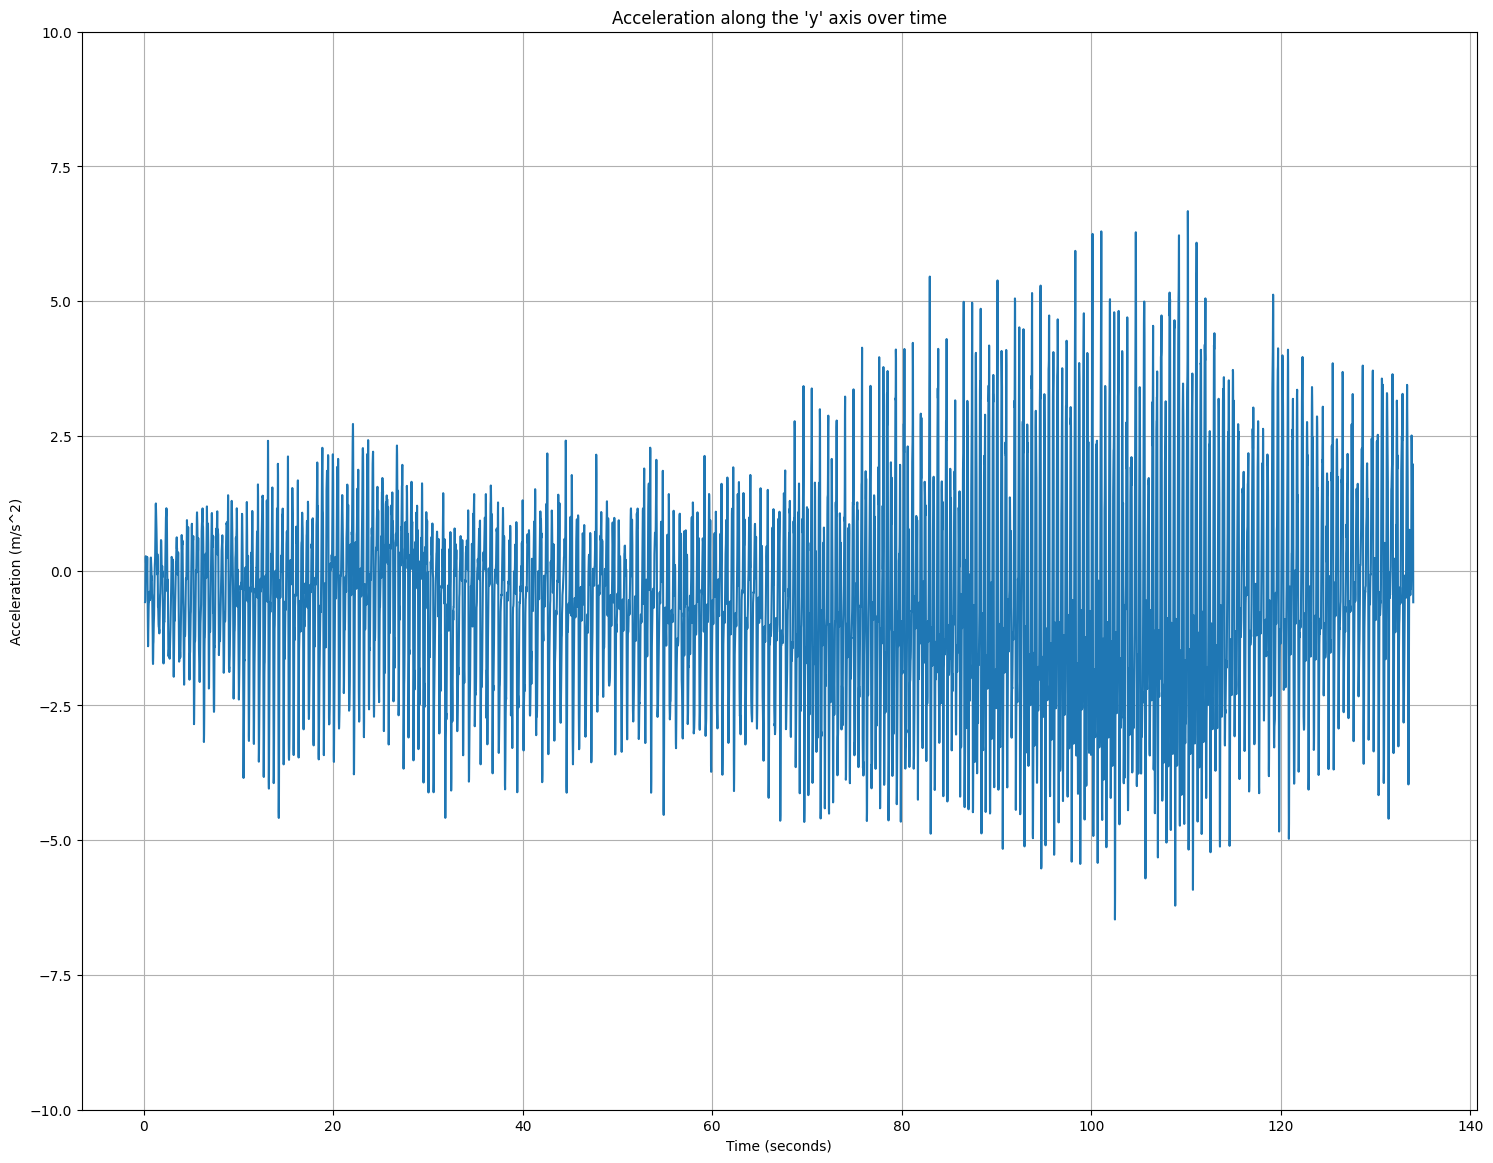

In [33]:
noisy_signal = acceleration['y']
time = acceleration['seconds_elapsed']

# Calculate time step
dt = (time.iloc[-1] - time.iloc[0]) / len(time)

# Plotting the signal
plt.figure(figsize=(18, 14))
plt.plot(time, noisy_signal)
plt.title("Acceleration along the 'y' axis over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s^2)")
plt.grid(True)
plt.ylim(-10, 10)  

In [35]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply the filter to the data
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    # Apply the filter to the data
    y = filtfilt(b, a, data)
    return y


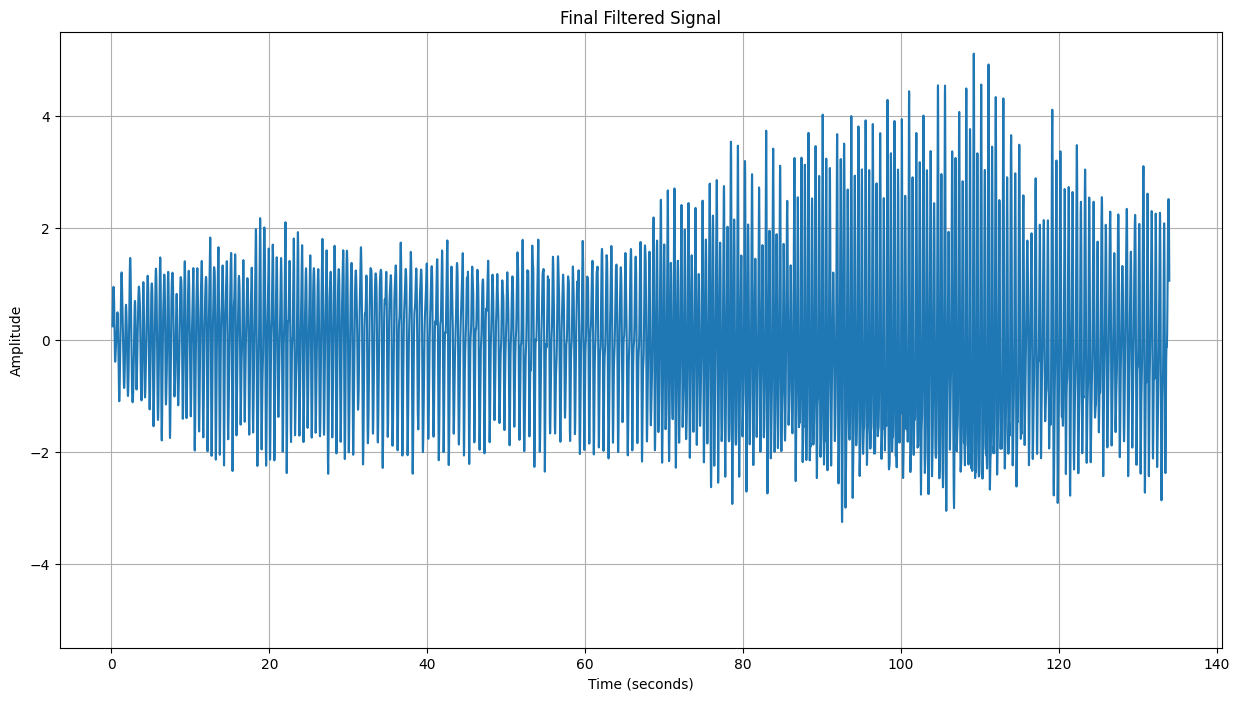

In [46]:
# Define the order of the filters
order = 2

# Calculate the sampling frequency
fs = 1 / dt

# Calculate the Nyquist frequency
nyq = 0.5 * fs

# Define the cutoff frequencies for the high-pass and low-pass filters
cutoff_H = 1 / 5  # High-pass cutoff frequency
cutoff_L = 1 / 0.5  # Low-pass cutoff frequency

# Apply the low-pass filter
lowpass_filtered = butter_lowpass_filter(noisy_signal, cutoff_L, nyq, order)

final_signal = butter_highpass_filter(lowpass_filtered, cutoff_H, nyq, order)

# Plot the final filtered signal
fig = plt.figure(figsize=(15, 8))
plt.plot(time, final_signal)
plt.grid(True)
plt.ylim(-5.5, 5.5) 
plt.title("Final Filtered Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [53]:

filtered_acceleration = np.array(final_signal)
sign_changes = np.where(np.diff(np.sign(filtered_acceleration)))[0]
number_of_steps = len(sign_changes) // 2
print("The number of steps is:", number_of_steps)

The number of steps is: 257


Q1:Does the acceleration calculated from the speed match the observed acceleration? What differences do you notice? What could be their cause?

The acceleration calculated from the speed and the observed acceleration exhibit significant differences. The observed acceleration, derived from the phone's sensors while it's in a pocket, reflects various vibrations and noise present in its environment. On the other hand, the calculated acceleration represents the overall motion of the body, filtering out many of these vibrations and noise. In essence, the observed acceleration primarily reflects the motion of the phone itself, whereas the calculated acceleration captures the motion of the body as a whole. These discrepancies arise due to the inherent differences in the sources of data and the methods used for calculation.

Q2:Is the number of steps logical?

Yes, considering the total distance covered (215.14 meters), the number of steps (257) appears reasonable. This estimation suggests an average step length that aligns with typical human gait patterns. However, variations in step length and pace can also influence the exact number of steps counted